In [1]:
# Importar librerias
import requests                    
import pandas as pd
import time             
import matplotlib.pyplot as plt    
import seaborn as sns               
import numpy as np                  
import datetime
import json
from pandas_geojson import to_geojson
from bs4 import BeautifulSoup
from selenium import webdriver
import seaborn as sns
import matplotlib.pyplot as plt
import io
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import re
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors
sns.set_style("darkgrid")


## "Japón."

Los datos sísmicos se descargaron a través de [JMA](https://www.data.jma.go.jp/multi/quake/index.html?lang=es) (agencia meteorologica de Japón).

El analisis se realiza en un intervalo de inicio el 01 de enero de 2023 y fin el 11 de mayo de 2023, o sea en un periodo de 130 días.

In [104]:

periodo_en_dias = (datetime.datetime(2023,5,11) - datetime.datetime(2023,1,1)).days
print('El periodo en días es igual a',periodo_en_dias,'días')

El periodo en días es igual a 130 días


Realizar la extraccion y creacion del DataFrame desde el enlace.

In [2]:
    
def extraccion_japon():
    
    # Crear enlace a la página web.
    japon = "https://service.iris.edu/fdsnws/event/1/query?starttime=2023-01-01T00:00:00&&endtime=2023-05-11T23:59:59&orderby=time&format=geocsv&maxlat=47.587&minlon=128.288&maxlon=157.029&minlat=30.234&nodata=404"
    
    # Crear dataframe con la tabla extraida del enlace.
    japon = pd.read_csv(japon, sep='|', skiprows=4)

    # Filtrar la palabra JAPAN en la variable EventLocationName.
    japon = japon[japon.EventLocationName.str.contains('JAPAN')]

    return japon

japon = extraccion_japon()

Visualizar los primeros elementos del DataFrame.

In [189]:
japon.head()

,EventID,Time,Latitude,Longitude,Depth,Author,ContributorID,MagType,Magnitude,EventLocationName
0,11694723,2023-05-11T09:52:44Z,42.3324,142.9855,63.921,us,us6000kb2d,Mww,5.2,"HOKKAIDO, JAPAN REGION"
1,11694572,2023-05-10T21:04:24Z,31.4516,138.4022,363.835,us,us6000kazb,mb,4.1,"SOUTHEAST OF HONSHU, JAPAN"
2,11694590,2023-05-10T19:16:41Z,35.1122,140.2223,35.875,us,us6000kayd,Mwr,5.2,"NEAR EAST COAST OF HONSHU, JAPAN"
3,11694222,2023-05-10T12:54:48Z,37.5782,137.3084,10.000,us,us6000kau6,mb,5.0,"NEAR WEST COAST OF HONSHU, JAPAN"
4,11694022,2023-05-09T23:42:02Z,39.8745,140.5307,155.215,us,us6000karh,mb,4.0,"EASTERN HONSHU, JAPAN"


Determinar el significado de cada variable.

- __EventID:__ _Identificador del evento._
- __Time:__ _Fecha y hora del evento._
- __Latitude:__ _Latitud del epicentro del sismo._
- __Longitude:__ _Longitud del epicentro del sismo._
- __Depth:__ _Profundidad del epicentro del sismo._
- __Author:__ _Autor de los datos del evento._
- __Catalog:__ _Catálogo al que pertenece el evento._
- __Contributor:__ _Nombre del grupo que contribuye al evento._
- __ContributorID:__ _Identificador del contribuidor._
- __MagTyoe:__ _Método de cálculo preferido de la magnitud del evento._
- __Magnitude:__ _Magnitud del evento._
- __MagAuthor:__ _Autor de la medida de magnitud._
- __EventLocationName:__ _Lugar del evento._
- __Country:__ _País donde ocurrió el evento._

La siguiente grafica determina que no existen valores faltantes en el DataFrame.

Text(0.5, 1.0, 'Porcentaje de datos por variable')

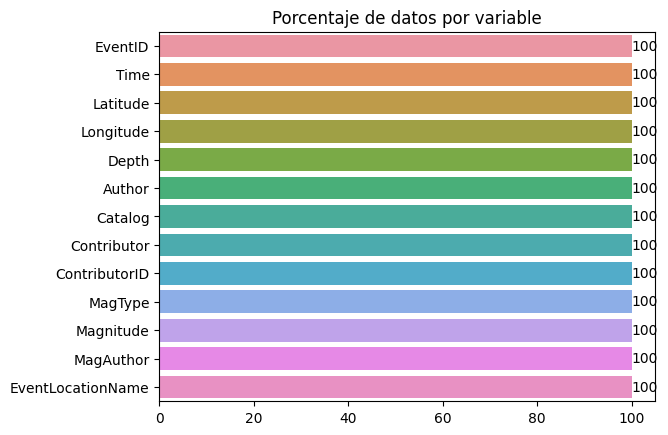

In [121]:
def datos_faltantes(pais):
    ax = sns.barplot(x = (pais.notnull().sum()*100/pais.shape[0]).values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Porcentaje de datos por variable')

datos_faltantes(japon)

In [117]:
print('El total de sismos en 130 días de Japón es', japon.shape[0])
print('La menor magnitud registrada es', japon.Magnitude.min())
print('La mayor magnitud registrada es',japon.Magnitude.max())

El total de sismos en 130 días de Japón es 192
La menor magnitud registrada es 3.9
La mayor magnitud registrada es 6.2


Las variables __Catalog__, __Contributor__ y __MagAuthor__ contienen un único valor, por lo tanto al ser un valor constante se deben eliminar.

Text(0.5, 1.0, 'Cantidad de valores únicos por variable')

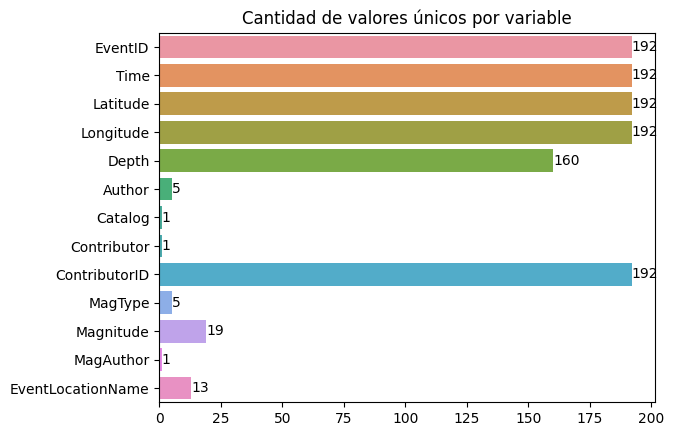

In [122]:
def valor_unico(pais):
    ax = sns.barplot(x = pais.nunique().values, y = pais.columns)
    ax.bar_label(ax.containers[0])
    return plt.title('Cantidad de valores únicos por variable')

valor_unico(japon)

Eliminar variables.

In [123]:
japon.drop(['Catalog','Contributor','MagAuthor'], axis=1, inplace=True)

El mapa de correlaciones determina que no existe correlacion lineal entre variables.

Text(0.5, 1.0, 'Mapa de correlacion')

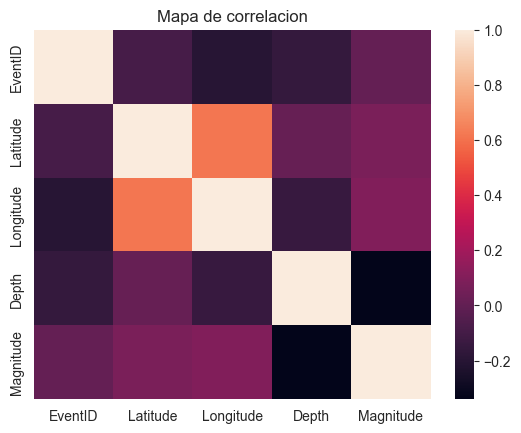

In [188]:
def mapa_correlacion(pais):

    sns.heatmap(pais.corr(numeric_only=True))
    return plt.title('Mapa de correlacion')

mapa_correlacion(japon)

C:\Users\Edwar\AppData\Local\Temp\ipykernel_2208\263671970.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


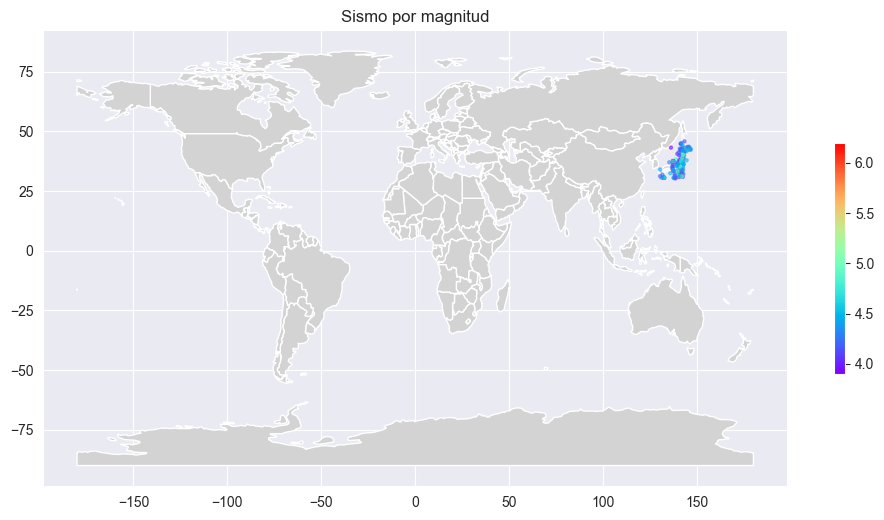

In [131]:

def mapa_sismo(pais):
    # https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    # Escogemos el mapa
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # Creamos el objeto geodataframe
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(pais['Longitude'], pais['Latitude'])]
    geo_df = gpd.GeoDataFrame(pais, 
                            crs = crs, 
                            geometry = geometry)

    # por magnitud
    fig, ax = plt.subplots(figsize = (12,10))

    world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

    geo_df.plot(column = 'Magnitude', ax=ax, cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 5, alpha=0.5)
                
    ax.set_title('Sismo por magnitud')

mapa_sismo(japon)

Convertir data frame a json.

In [132]:
japon_json = japon.to_json(orient = 'records')
print(japon_json)

[{"EventID":11694723,"Time":"2023-05-11T09:52:44Z","Latitude":42.3324,"Longitude":142.9855,"Depth":63.921,"Author":"us","ContributorID":"us6000kb2d","MagType":"Mww","Magnitude":5.2,"EventLocationName":"HOKKAIDO, JAPAN REGION"},{"EventID":11694572,"Time":"2023-05-10T21:04:24Z","Latitude":31.4516,"Longitude":138.4022,"Depth":363.835,"Author":"us","ContributorID":"us6000kazb","MagType":"mb","Magnitude":4.1,"EventLocationName":"SOUTHEAST OF HONSHU, JAPAN"},{"EventID":11694590,"Time":"2023-05-10T19:16:41Z","Latitude":35.1122,"Longitude":140.2223,"Depth":35.875,"Author":"us","ContributorID":"us6000kayd","MagType":"Mwr","Magnitude":5.2,"EventLocationName":"NEAR EAST COAST OF HONSHU, JAPAN"},{"EventID":11694222,"Time":"2023-05-10T12:54:48Z","Latitude":37.5782,"Longitude":137.3084,"Depth":10.0,"Author":"us","ContributorID":"us6000kau6","MagType":"mb","Magnitude":5.0,"EventLocationName":"NEAR WEST COAST OF HONSHU, JAPAN"},{"EventID":11694022,"Time":"2023-05-09T23:42:02Z","Latitude":39.8745,"Long

Guardar datos en un archivo json.

In [65]:
with open('datos_japon.json', 'w') as f:
    f.write(japon_json)

<a href="https://colab.research.google.com/github/Mezgo/Quake-Alert/blob/Codigo/etl/EDA_ETL_chile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importamos las librerias
import requests                     # hacer request a la pagina
import pandas as pd                 # dataframes
import matplotlib.pyplot as plt     # plots
import seaborn as sns               # plots
import datetime                     # formato de fechas
              

In [ ]:
# definir la URL de la API de la USGS para obtener datos de sismos
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

# definir los parámetros de la consulta
params = {
    'format': 'geojson',
    'starttime': '2023-01-01',
    'endtime': '2023-05-11',
    'minmagnitude': '1',
    'maxlatitude': '-17.5',
    'minlatitude': '-56.0',
    'maxlongitude': '-66.0',
    'minlongitude': '-81.0',
}

# hacer la consulta a la API
response = requests.get(url, params=params)

# cargar los datos en un DataFrame de Pandas
data = response.json()['features']
df = pd.json_normalize(data)

# seleccionar solo las columnas de interés
cols = ['properties.mag', 'properties.place', 'geometry.coordinates', 'properties.time']
df = df[cols]

# renombrar las columnas
df.columns = ['magnitud', 'lugar', 'coordenadas', 'fecha']

# imprimir el DataFrame resultante
print(df)


In [ ]:
df.head()

,magnitud,lugar,coordenadas,fecha
0,4.1,"45 km WNW of Abra Pampa, Argentina","[-66.075, -22.5145, 295.673]",1683623754342
1,4.4,"56 km WSW of Atocha, Bolivia","[-66.744, -21.0683, 236.151]",1683593777052
2,4.6,"Near the coast of Atacama, Chile","[-71.3262, -28.6913, 37.684]",1683513242863
3,4.4,"Jujuy, Argentina","[-66.8884, -23.3425, 235.3]",1683444623676
4,5.2,"Near the coast of Antofagasta, Chile","[-70.5066, -25.3571, 40.047]",1683440940792


la columna coodenada sus valores significan:

El primer valor, -66.075, es la longitud en grados decimales. En este caso, indica que el sismo ocurrió al oeste del meridiano de Greenwich, en algún punto entre Chile y Argentina.
El segundo valor, -22.5145, es la latitud en grados decimales. En este caso, indica que el sismo ocurrió al sur del ecuador, en algún punto al sur de Chile.
El tercer valor, 295.673, es la profundidad en kilómetros. Indica la distancia vertical desde la superficie de la tierra hasta el punto donde se originó el sismo

In [ ]:
#aca separamos la columna coordenadas en latitud, longitud y profundidad
df[['longitud', 'latitud', 'profundidad']] = pd.DataFrame(df['coordenadas'].tolist(), index=df.index)

In [ ]:
df.head(2)

,magnitud,lugar,coordenadas,fecha,longitud,latitud,profundidad
0,4.1,"45 km WNW of Abra Pampa, Argentina","[-66.075, -22.5145, 295.673]",1683623754342,-66.075,-22.5145,295.673
1,4.4,"56 km WSW of Atocha, Bolivia","[-66.744, -21.0683, 236.151]",1683593777052,-66.744,-21.0683,236.151


In [ ]:
# Eliminar la columna original de "coordenadas"
df.drop(columns=['coordenadas'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitud     292 non-null    float64
 1   lugar        281 non-null    object 
 2   fecha        292 non-null    int64  
 3   longitud     292 non-null    float64
 4   latitud      292 non-null    float64
 5   profundidad  292 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 13.8+ KB


In [ ]:
#transformamos fecha en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'], unit='ms')

In [ ]:
df.head(2)

,magnitud,lugar,fecha,longitud,latitud,profundidad
0,4.1,"45 km WNW of Abra Pampa, Argentina",2023-05-09 09:15:54.342,-66.075,-22.5145,295.673
1,4.4,"56 km WSW of Atocha, Bolivia",2023-05-09 00:56:17.052,-66.744,-21.0683,236.151


In [ ]:
df.describe(exclude='number')

<ipython-input-38-38d271b0689f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(exclude='number')


,lugar,fecha
count,281,292
unique,244,292
top,"Near the coast of Coquimbo, Chile",2023-05-09 09:15:54.342000
freq,7,1
first,NaN,2023-01-01 12:18:59.423000
last,NaN,2023-05-09 09:15:54.342000


In [ ]:
df['fecha_local'] = df['fecha'].dt.date
df['hora_local'] = df['fecha'].dt.time

In [ ]:
df.head(2)

,magnitud,lugar,fecha,longitud,latitud,profundidad,fecha_local,hora_local
0,4.1,"45 km WNW of Abra Pampa, Argentina",2023-05-09 09:15:54.342,-66.075,-22.5145,295.673,2023-05-09,09:15:54.342000
1,4.4,"56 km WSW of Atocha, Bolivia",2023-05-09 00:56:17.052,-66.744,-21.0683,236.151,2023-05-09,00:56:17.052000


In [ ]:
#son lugares donde ocurrieron los sismos aunque estan fuera de chile se sintieron en chile
df['lugar'].unique()

In [ ]:
#borramos fecha
df.drop(columns=['fecha'], inplace=True)

In [ ]:
#aca solo dejamos horas y minutos

df['hora_local'] = df['hora_local'].apply(lambda x: x.strftime('%H:%M'))

In [ ]:
df.head(2)

,magnitud,lugar,longitud,latitud,profundidad,fecha_local,hora_local
0,4.1,"45 km WNW of Abra Pampa, Argentina",-66.075,-22.5145,295.673,2023-05-09,09:15
1,4.4,"56 km WSW of Atocha, Bolivia",-66.744,-21.0683,236.151,2023-05-09,00:56


In [ ]:
df.isnull().sum()

magnitud        0
lugar          11
longitud        0
latitud         0
profundidad     0
fecha_local     0
hora_local      0
dtype: int64

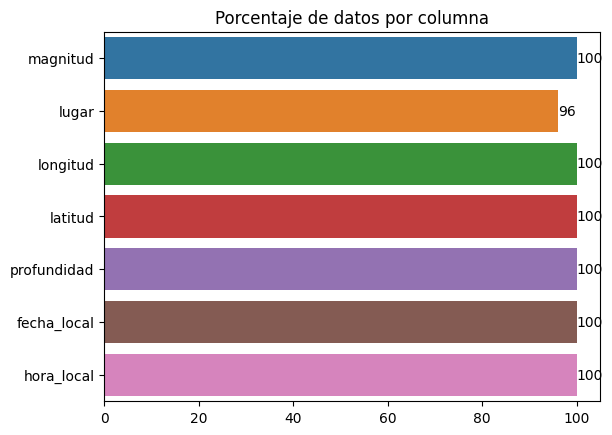

In [ ]:
ax = sns.barplot(x = (round(df.notnull().sum()*100/df.shape[0])).values, y = df.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de datos por columna');

In [ ]:
# Verificar si hay filas duplicadas
if df.duplicated().any():
    print("Hay filas duplicadas")
else:
    print("No hay filas duplicadas")

No hay filas duplicadas


In [ ]:
df

,magnitud,lugar,longitud,latitud,profundidad,fecha_local,hora_local
0,4.1,"45 km WNW of Abra Pampa, Argentina",-66.0750,-22.5145,295.673,2023-05-09,09:15
1,4.4,"56 km WSW of Atocha, Bolivia",-66.7440,-21.0683,236.151,2023-05-09,00:56
2,4.6,"Near the coast of Atacama, Chile",-71.3262,-28.6913,37.684,2023-05-08,02:34
3,4.4,"Jujuy, Argentina",-66.8884,-23.3425,235.300,2023-05-07,07:30
4,5.2,"Near the coast of Antofagasta, Chile",-70.5066,-25.3571,40.047,2023-05-07,06:29
...,...,...,...,...,...,...,...
287,4.5,"25 km ENE of San Martín, Argentina",-68.2466,-31.3613,105.312,2023-01-02,11:24
288,4.5,"62 km W of San Antonio de los Cobres, Argentina",-66.9233,-24.1203,195.266,2023-01-02,06:45
289,4.4,"Potosi, Bolivia",-67.2105,-21.3126,201.911,2023-01-01,21:32
290,4.1,"136 km N of Calama, Chile",-68.9621,-21.2221,90.462,2023-01-01,13:27


In [ ]:
df.drop(columns=['lugar'], inplace=True)

In [ ]:
df.head(2)

,magnitud,longitud,latitud,profundidad,fecha_local,hora_local
0,4.1,-66.075,-22.5145,295.673,2023-05-09,09:15
1,4.4,-66.744,-21.0683,236.151,2023-05-09,00:56


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitud     292 non-null    float64
 1   longitud     292 non-null    float64
 2   latitud      292 non-null    float64
 3   profundidad  292 non-null    float64
 4   fecha_local  292 non-null    object 
 5   hora_local   292 non-null    object 
dtypes: float64(4), object(2)
memory usage: 13.8+ KB


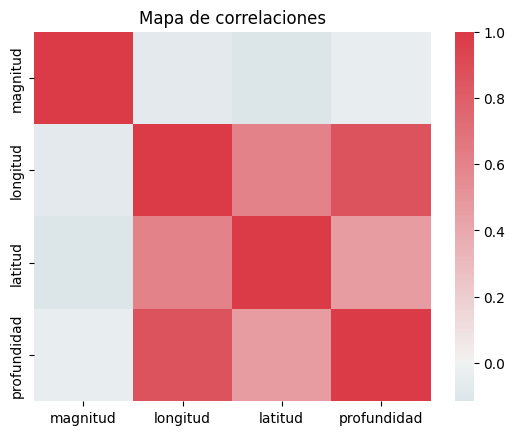

In [ ]:


# Generar mapa de correlaciones con paleta de colores personalizada
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(numeric_only=True), cmap=cmap, center=0)
plt.title('Mapa de correlaciones')
plt.show()


Correlación positiva fuerte: Los valores cercanos a 1 sugieren una relación positiva fuerte entre las variables. Esto implica que cuando una variable aumenta, es probable que la otra variable también aumente.

Correlación negativa fuerte: Los valores cercanos a -1 sugieren una relación negativa fuerte entre las variables. Esto implica que cuando una variable aumenta, es probable que la otra variable disminuya.

La conclusión de este mapa de correlación es que hay una gran relación entre profundidad y longitud, y en menos insidencia latidud y longitud

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.4 MB/s eta 0:00:00


In [ ]:
# Graficar en mapa con latitud y longitud
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors


sns.set_style("darkgrid")

In [ ]:
df.columns


Index(['magnitud', 'longitud', 'latitud', 'profundidad', 'fecha_local',
       'hora_local'],
      dtype='object')

<ipython-input-59-7923a63429a5>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


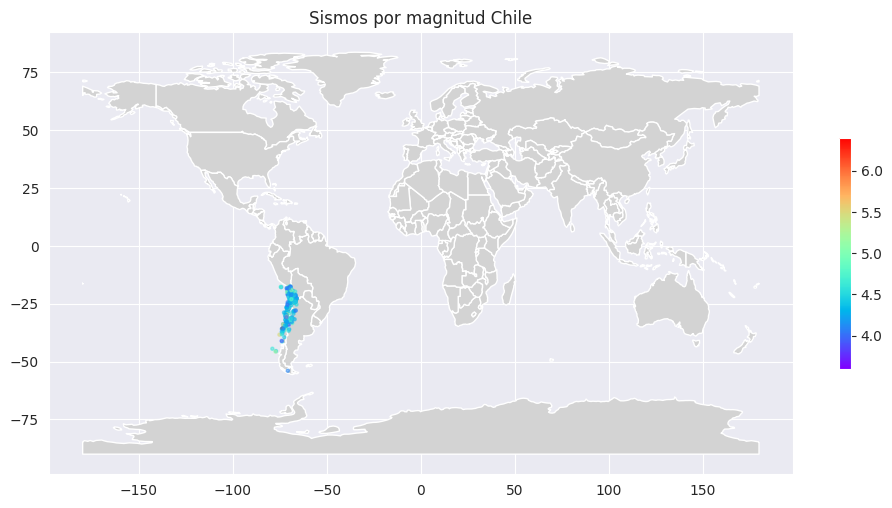

In [ ]:
# https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
# Escogemos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Creamos el objeto geodataframe
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)

# por magnitud
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'magnitud', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.5)
            
ax.set_title('Sismos por magnitud Chile');

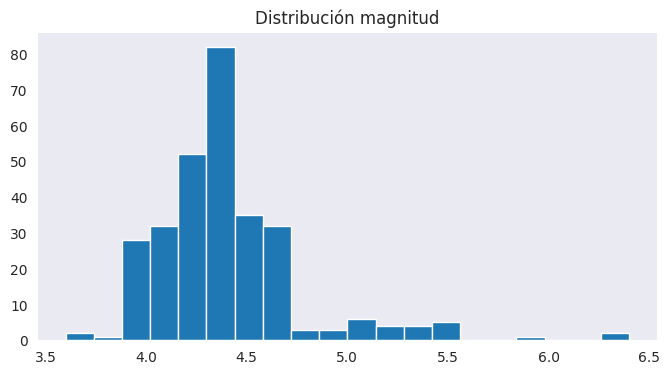

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df['magnitud'], bins=20)
plt.title('Distribución magnitud')
plt.grid()
plt.show()

 La mayoría de los sismos registrados tienen una magnitud que oscila entre 4 y 4.6. Esto sugiere que los sismos más comunes en la región o período de estudio son de intensidad moderada.
Este gráfico nos muestra que la mayoría de los sismos que ocurren en Chile son 4.4 grados en escala de Ritcher

In [ ]:
df.to_json('chile.json')


In [ ]:
from google.colab import files

files.download('chile.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

$$
EEUU
$$

* Analsis de datos extraidos de [USGS](https://earthquake.usgs.gov/fdsnws/event/1/) (El Servicio Geologico de los Estados Unidos )

In [ ]:
import requests
import json, csv

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&endtime=now'
response = requests.get(url)


Guardar info en archivo .json

In [ ]:
data = response.text

with open('datos_usa.json', 'w') as f:
    f.write(data)

Leer archivo json

In [ ]:
with open('datos_usa.json','r') as f:
    data = json.loads(f.read())

In [ ]:
df = pd.json_normalize(data,
                       record_path=['features'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11502 entries, 0 to 11501
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  11502 non-null  object 
 1   id                    11502 non-null  object 
 2   properties.mag        11502 non-null  float64
 3   properties.place      11193 non-null  object 
 4   properties.time       11502 non-null  int64  
 5   properties.updated    11502 non-null  int64  
 6   properties.tz         0 non-null      object 
 7   properties.url        11502 non-null  object 
 8   properties.detail     11502 non-null  object 
 9   properties.felt       656 non-null    float64
 10  properties.cdi        656 non-null    float64
 11  properties.mmi        122 non-null    float64
 12  properties.alert      57 non-null     object 
 13  properties.status     11502 non-null  object 
 14  properties.tsunami    11502 non-null  int64  
 15  properties.sig     

In [ ]:
df.shape

(11502, 30)

In [ ]:
df.head(2)

,type,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,...,properties.types,properties.nst,properties.dmin,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates
0,Feature,ak0235za9d84,1.5,None,1683740770447,1683740868156,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",NaN,NaN,0.41,NaN,ml,earthquake,M 1.5 -,Point,"[-148.7179, 63.854, 13.5]"
1,Feature,ak0235za4vu1,2.1,"13 km NW of Happy Valley, Alaska",1683739518811,1683739606608,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,",origin,phase-data,",NaN,NaN,0.36,NaN,ml,earthquake,"M 2.1 - 13 km NW of Happy Valley, Alaska",Point,"[-151.9141, 60.0289, 79.4]"


In [ ]:
df.columns

Index(['type', 'id', 'properties.mag', 'properties.place', 'properties.time',
       'properties.updated', 'properties.tz', 'properties.url',
       'properties.detail', 'properties.felt', 'properties.cdi',
       'properties.mmi', 'properties.alert', 'properties.status',
       'properties.tsunami', 'properties.sig', 'properties.net',
       'properties.code', 'properties.ids', 'properties.sources',
       'properties.types', 'properties.nst', 'properties.dmin',
       'properties.rms', 'properties.gap', 'properties.magType',
       'properties.type', 'properties.title', 'geometry.type',
       'geometry.coordinates'],
      dtype='object')

Se evidencia que las siguientes columnas tienen lo que parece un nombre compuesto. Esto se debe al aplanamiento del formato GeoJson para hacer posible su ajuste a _Pandas_. Entiendace a _properties_ como las propiedades del evento sismico y a _geometry_ como la forma de ubicar y graficar dicho evento un mapa.

Significado de algunas de sus columnas:

1. `type`: es un atributo heredado de la notacion _GeoJson_ que se refiere a la categoria a la que pertence la informacion de la fila.

2. `id`: identificador unico del evento sismico registrado.


> En adelante se explicaran las columnas pasando por alto (_properties._ y _geometry._).


3. `mag`: es la magnitud del sismo, que mide la energía liberada en el evento. La escala más comúnmente utilizada para medir la magnitud es la escala de Richter.

4. `place`: es la ubicación geográfica del sismo, que generalmente se expresa en términos de la ciudad o el estado más cercano al epicentro.

5. `time`: indica la fecha y hora exacta en que ocurrió el sismo, expresada en _timestamp_.

6. `updated`: es la fecha y hora en que se actualizó la información sobre el evento sísmico en la base de datos. Esta información puede actualizarse a medida que se recopilan más datos sobre el sismo. Formato _timestamp_.

7. `tz`: abreviado de _timezone_. Zona horaria de la ubicacion del evento.

8. `url`: link a la informacion del evento.

9. `detail`: link a la descripción del evento.

10. `felt`: ubicaciones en las que se sintio el evento.

11. `net`: es el código de identificación de la red sísmica que registró el evento. Por ejemplo, la red sísmica de Estados Unidos es la USGS (United States Geological Survey) y su código es "us".

12. `type`: se refiere al tipo de evento sísmico registrado, que puede ser un sismo, una réplica o una explosión.

13. `nst`: se refiere al número de estaciones sismográficas que registraron el evento.

14. `dimn`: es la dimensión del evento en kilómetros.

15. `rms`: es el error de tiempo de la solución de ubicación del sismo en segundos.

16. `gap`:el ángulo de brecha indica la cantidad de información que falta para calcular la ubicación exacta y la magnitud del sismo, debido a que la red de estaciones sismográficas no tiene una cobertura completa del área afectada por el evento sísmico.

17. `magType`: indica la escala o método utilizado para calcular la magnitud del sismo, como por ejemplo, la escala de Richter, la escala de magnitud de momento o la escala de magnitud de onda superficial. Los sinificados de sus valores son los siguientes:

    - "md": se refiere a la magnitud calculada usando la escala de duración, que es una escala de magnitud basada en la duración de la onda sísmica.

    - "ml": se refiere a la magnitud calculada usando la escala de Richter, que es una escala de magnitud que se basa en la amplitud de las ondas sísmicas registradas en un sismógrafo.


    - "mb": se refiere a la magnitud calculada usando la escala de onda de cuerpo superficial, que se basa en la amplitud de las ondas sísmicas de cuerpo y superficie.


    - "mww": se refiere a la magnitud calculada usando la escala de momento sísmico, que es una escala de magnitud basada en la cantidad total de energía liberada durante el sismo.


    - "mlr": se refiere a la magnitud calculada usando la escala de Richter revisada, que es una versión actualizada y mejorada de la escala de Richter original.


    - "mb_lg": se refiere a la magnitud calculada usando una combinación de las escalas de onda de cuerpo y superficie (mb) y la escala de Richter (lg).


    - "mw": se refiere a la magnitud calculada usando la escala de momento sísmico, pero ajustada para tener en cuenta la atenuación de la energía sísmica en el camino desde el epicentro hasta la superficie.


    - "mwr": se refiere a la magnitud calculada usando una versión modificada de la escala de momento sísmico que tiene en cuenta la orientación de las fallas geológicas.


    - "mlv": se refiere a la magnitud calculada usando la escala de Richter local, que es una versión adaptada de la escala de Richter para sismos locales.


    - "mh": se refiere a la magnitud calculada usando la escala de hipocentro, que es una escala de magnitud que tiene en cuenta la profundidad y ubicación del hipocentro del sismo.

18. `coordinates`: contiene las coordenadas de la ubicacion geografica en la que ocurrio el evento y su profundidad.

In [ ]:
df.describe(exclude='number')

,type,id,properties.place,properties.tz,properties.url,properties.detail,properties.alert,properties.status,properties.net,properties.code,properties.ids,properties.sources,properties.types,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates
count,11502,11502,11193,0,11502,11502,57,11502,11502,11502,11502,11502,11502,11502,11502,11502,11502,11502
unique,1,11502,5767,0,11502,11502,2,2,15,11502,11502,77,55,11,6,8895,1,11502
top,Feature,ak0235za9d84,"7km NW of The Geysers, CA",NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,green,reviewed,ak,0235za9d84,",ak0235za9d84,",",ak,",",origin,phase-data,",ml,earthquake,"M 0.8 - 7km NW of The Geysers, CA",Point,"[-148.7179, 63.854, 13.5]"
freq,11502,1,155,NaN,1,1,55,9990,3275,1,1,2931,7982,7740,11251,36,11502,1


el ultimo gran sismo 20 de abril 2023, medido en escala de richter, se registro en alaska a 7 kilómetros al noroeste de The Geysers, California.El evento ha sido revisado y confirmado por un sismólogo o un experto en la materia."ak" es la agencia responsable de la detección y registro del evento.

In [ ]:
thee_features ='properties.mag', 'properties.time', 'properties.type','geometry.coordinates']

for col in df.columns:
    if col not in thee_features:
        del df[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11502 entries, 0 to 11501
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11502 non-null  object 
 1   properties.mag        11502 non-null  float64
 2   properties.time       11502 non-null  int64  
 3   properties.type       11502 non-null  object 
 4   geometry.coordinates  11502 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 449.4+ KB


## Observacion de datos en bruto

In [ ]:
d= df.dtypes
vars = []
for i, el in enumerate(d):
    # print(d.index[i])
    # print(el)
    if  el != object:
        vars.append(d.index[i])
vars

['properties.mag',
 'properties.time',
 'properties.updated',
 'properties.felt',
 'properties.cdi',
 'properties.mmi',
 'properties.tsunami',
 'properties.sig',
 'properties.nst',
 'properties.dmin',
 'properties.rms',
 'properties.gap']

In [ ]:
class Analisis_Grafico:
        def __init__(self,df):

                self.df = df
        def matriz_correlacion(self,pais,variables):
                #grafico para ver la relación entre las variable
                # Seleccionar las columnas a incluir en la matriz de correlación
                cols = variables

                # Crear la matriz de correlación
                corr = self.df[cols].corr()

                # Crear el gráfico de correlación utilizando la biblioteca Seaborn
                sns.set(style="white")
                mask = np.triu(np.ones_like(corr, dtype=np.bool_))
                fig, ax = plt.subplots(figsize=(10, 8))
                cmap = sns.diverging_palette(220, 10, as_cmap=True)
                sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})
                plt.title('Matriz de correlación de los datos de sismos en '+pais)
                return plt.show()


In [ ]:
EEUU = Analisis_Grafico(df)

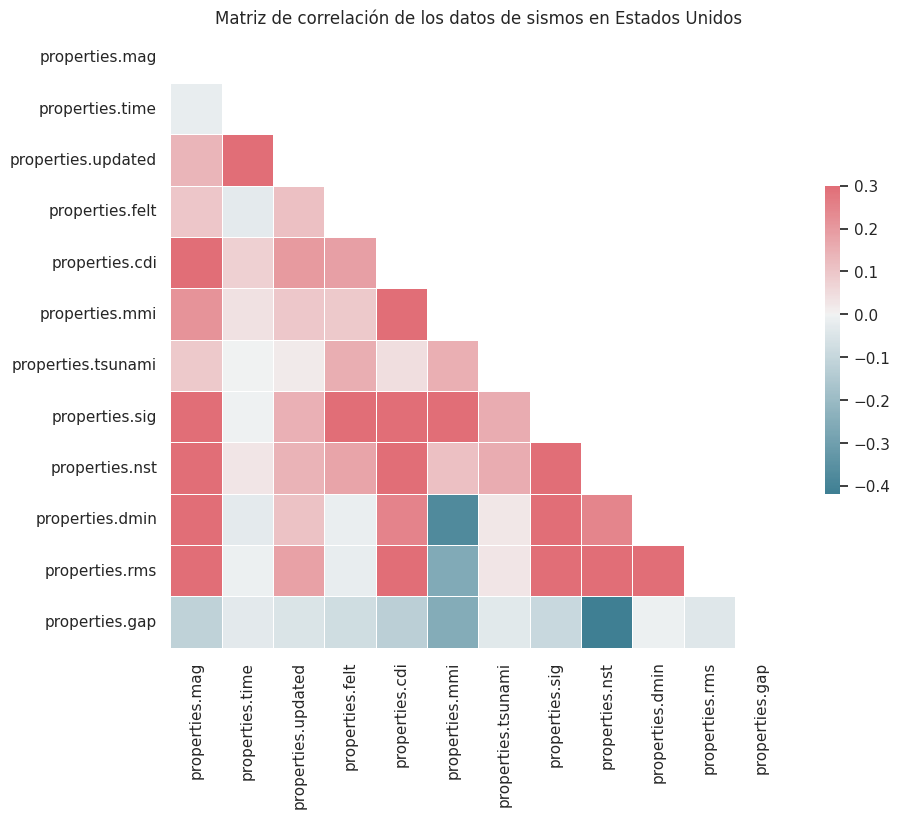

In [ ]:
EEUU.matriz_correlacion('Estados Unidos',vars)

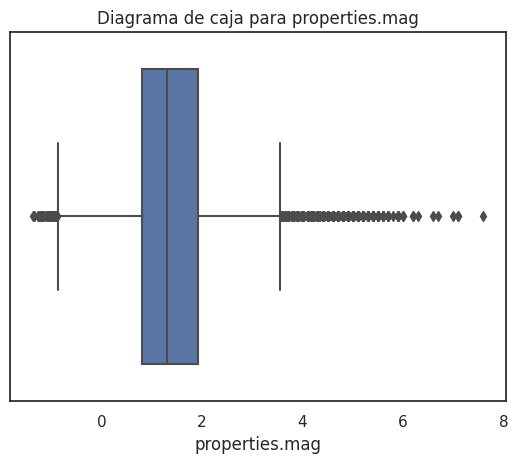

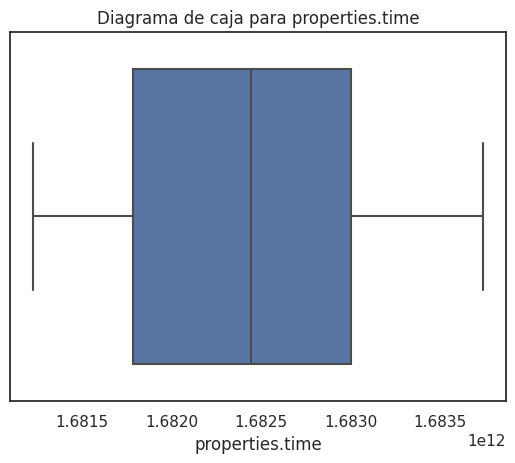

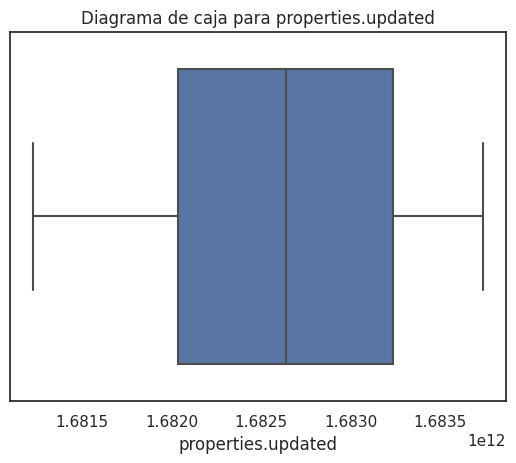

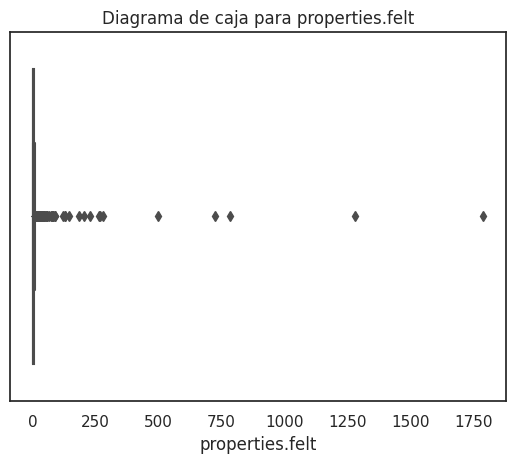

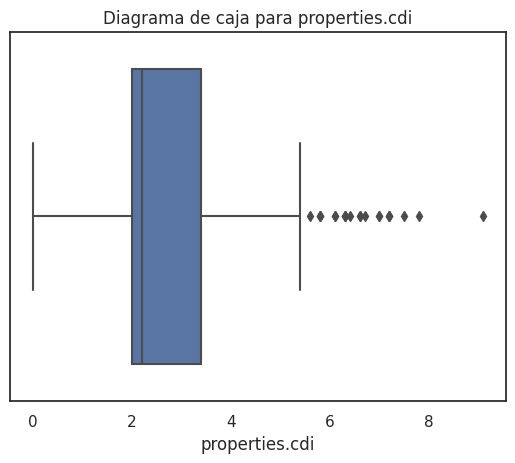

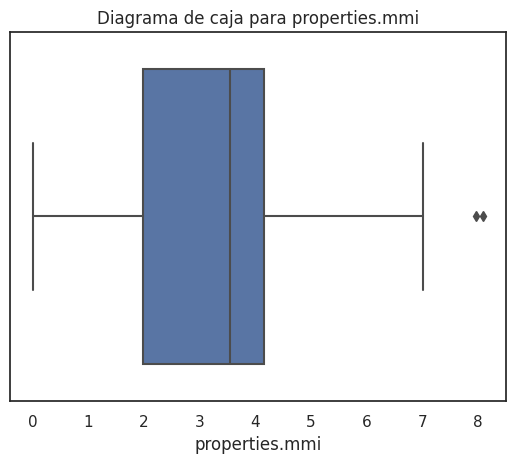

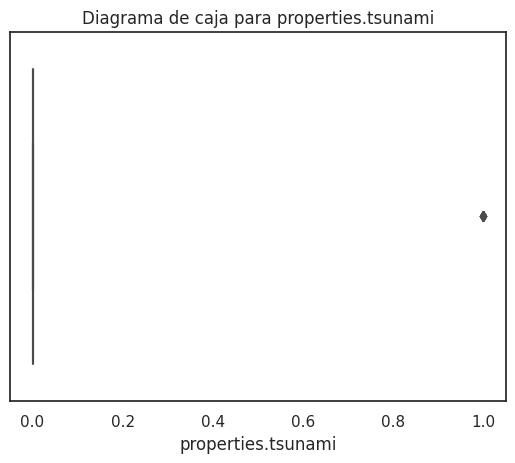

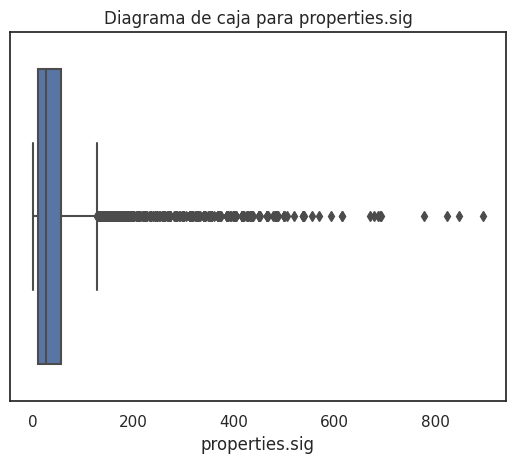

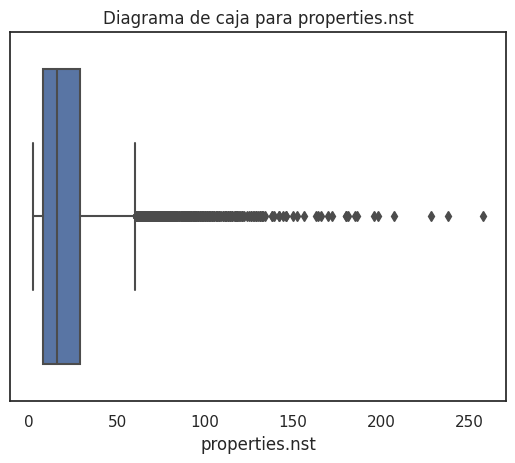

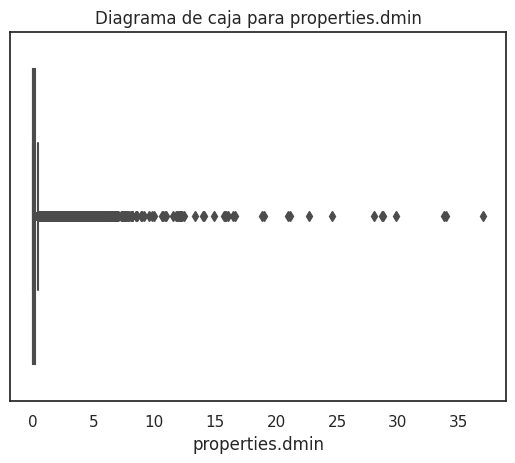

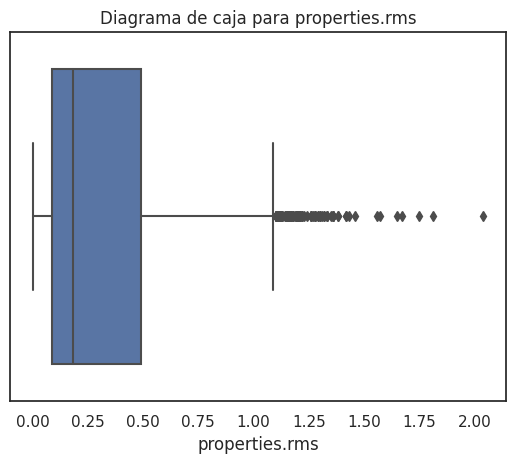

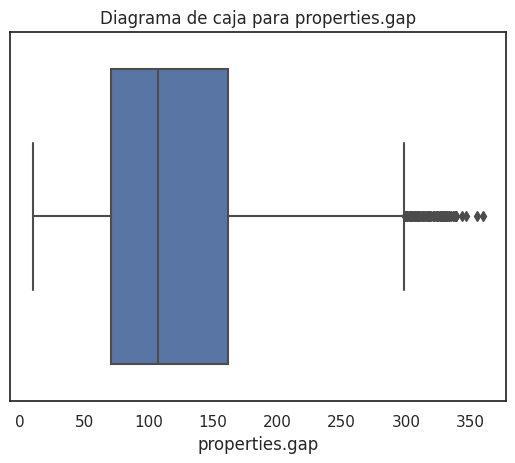

In [ ]:
#aca se genera un diagrama de caja para ver los outlier

# Crear un diagrama de caja para cada columna utilizando la biblioteca Seaborn
for var in vars:
    plt.figure()
    sns.boxplot(x=df[var])
    plt.title('Diagrama de caja para ' + var)
    plt.show()
